# RNA Secondary Structure Prediction Pipelines

This notebook predicts RNA secondary structure using pipelines composed of the
following units:

- Global structure estimator (GSE)
- Local structure refiner (LSR)
- Monomialization unit (MU)
- Binarization unit (BU)
- Symmetrization unit (SU)
- Constraint unit (CU)
- Threshold unit (TU)
- Noise removal unit (NRU)
- Output unit: SU -> CU -> MU -> BU -> NRU (OU)

The last pipeline components are always OU.

In [1]:
import json
from random import sample

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate, segment
from diurnal.models import deep
from diurnal.models.deep import cnn

## Data Preparation

In [2]:
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
SUBDIVISION_SIZE = 32  # Kernel size of the local structure refiner.

database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-12T10:41:46.997344 > INFO Download and install an RNA database.
2024-06-12T10:41:47.025491 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-12T10:41:47.028273 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:30<00:00, 131.05it/s]


2024-06-12T10:42:17.393306 >     Detected 3975 files. Kept 2326 files.
2024-06-12T10:42:17.412608 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [3]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )

format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-12T10:42:17.436871 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-12T10:42:17.599438 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-12T10:42:17.601753 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-12T10:42:17.658975 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-12T10:42:17.662517 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_onehot.npy`.
2024-06-12T10:42:17.694460 >     The file `./data/archiveII_processed_128/validation/primary_onehot.npy` already contains the formatted data.
2024-06-12T10:42:17.700174 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_contact.npy`.
2

In [4]:
def format_data() -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}train/secondary_contact.npy"),
        "mask": np.load(f"{DST}train/primary_masks.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}validation/secondary_contact.npy"),
        "mask": np.load(f"{DST}validation/primary_masks.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


# Create a training set for the LSR.
from os import mkdir
from tqdm import tqdm


def save_global_estimations(model, data, name):
    try:
        mkdir("tmp")
    except:
        pass

    predictions = []
    for i in tqdm(range(len(data["input"][0]))):
        p = model.predict([data["input"][0][i]])
        predictions.append(p)
    np.save(f"tmp/{name}", np.array(predictions))


FIRST = 16  # Select the most important areas.
RANDOM = 8  # Select random areas after the FIRST ones.
STRIDE = 16


def sample_crops(predictions, data, name, maximum, t = 0) -> list:
    predict_crops = []
    pp_crops = []  # Potential pairings
    contact_crops = []
    for index in tqdm(range(len(predictions))):
        prediction = predictions[index] * predictions[index].T * data["mask"][index]
        all_crops = segment.sample_areas(
            prediction, SUBDIVISION_SIZE, stride=STRIDE, threshold=t
        )
        if len(all_crops) > FIRST:
            difference = len(all_crops) - FIRST
            sampling = min(difference, RANDOM)
            if sampling:
                crops = all_crops[:FIRST] + sample(all_crops[FIRST:], sampling)
            else:
                crops = all_crops[:FIRST]
        else:
            crops = all_crops

        for crop, _ in crops:
            predict_crops.append(
                predictions[index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            pp_crops.append(
                data["input"][0][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            contact_crops.append(
                data["output"][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )

        if len(predict_crops) >= maximum:
            break

    np.save(f"tmp/{name}_areas_prediction_{SUBDIVISION_SIZE}.npy", np.array(predict_crops))
    np.save(f"tmp/{name}_areas_pp_{SUBDIVISION_SIZE}.npy", np.array(pp_crops))
    np.save(f"tmp/{name}_areas_contact_{SUBDIVISION_SIZE}.npy", np.array(contact_crops))


def format_refiner_data() -> tuple:
    train_set = {
        "input": (
            np.load(f"tmp/train_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/train_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/train_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    validation_set = {
        "input": (
            np.load(f"tmp/validation_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/validation_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/validation_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    test_set = {
        "input": (
            np.load(f"tmp/test_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/test_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/test_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


def refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE)):
        row = v_stride * SUBDIVISION_SIZE
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE)):
            column = h_stride * SUBDIVISION_SIZE
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] = prediction
    return result


def dense_refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE) * 2 - 1):
        row = int(v_stride / 2 * SUBDIVISION_SIZE)
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE) * 2 - 1):
            column = int(h_stride /2 * SUBDIVISION_SIZE)
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] += prediction
    return result / 2

In [5]:
def MU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_monomial_matrix(matrix)


def BU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_binary_matrix(matrix)


def SU(matrix: np.ndarray) -> np.ndarray:
    return matrix * matrix.T


def CU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    return matrix * mask


def TU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return (matrix < threshold) * matrix


def NRU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return segment.convolutional_denoise(matrix, threshold=threshold)


def NU(matrix: np.ndarray) -> np.ndarray:
    normalized = matrix.copy()
    maximum = normalized.max()
    normalized[normalized == 0] = 2
    minimum = normalized.min()
    normalized -= minimum
    normalized *= 1 / (maximum - minimum)
    normalized[normalized > 1] = 0
    return normalized


def OU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    matrix = CU(matrix, mask)
    matrix = SU(matrix)
    matrix = MU(matrix)
    matrix = BU(matrix)
    matrix = NRU(matrix, 2)
    return matrix

In [6]:
def inspect(model, data: dict, i: int) -> None:
    t = data["output"][i]
    p = model(data["input"][0][i], data["mask"][i])
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")


def measure_performances(model, data) -> list[float]:
    scores = []
    for i in range(len(data["output"])):
        t = data["output"][i]
        p = model(data["input"][0][i], data["mask"][i])
        f = evaluate.ContactMatrix.f1(t, p)
        scores.append(f)
    print(f"F1 scores: {scores}")
    print(f"Arithmetic mean: {np.mean(scores)}")
    return scores

## GSE

In [63]:
train_data, validation_data, test_data = format_data()


from torch import nn, reshape, cat, stack, squeeze, Tensor, mean, ones_like, log
import torch.nn.functional as F

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma_p = 0.1
        self.gamma_n = 10
    def forward(self, p, y):
        """
        L: Loss
        y: True structure
        p: Prediction
        Lp: Positive loss (i.e. loss associated to 1 (paired) labels)
        Ln: Negative loss (i.e. loss associated to 0 (unpaired) labels)
        gp: Positive gamme focus parameter
        gn: Negative gamme focus parameter

        L = -y Lp - (1 - y)Ln

        Lp = (1 - p)^gp log(p)
        Ln = p^gn log(1 - p)

        with gn > gp (emphasize the contribution of positive samples).
        """
        Lp = (ones_like(p) - p)**self.gamma_p * log(p)
        Ln = p**self.gamma_n * log(ones_like(p) - p)
        return (-1.0 * y * Lp - (ones_like(p) - y) * Ln).sum()


N_MAX_EPOCHS = 100
GSE = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    #loss_fn=CustomLoss, # 0.123
    loss_fn=nn.CrossEntropyLoss, # 0.684
    use_half=False,
    patience=10,
    verbosity=2,
)
GSE.train(train_data, validation_data)

def model_1(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = OU(x, mask)
    return x

2024-06-12T12:03:30.416194 > INFO Training the model with 1860 data points.
2024-06-12T12:03:30.419709 >     Using 232 data points for validation.
2024-06-12T12:03:30.422240 >     Beginning the training.
2024-06-12T12:03:31.718918 >   0 / 100 [                                                  ] Loss: 2.13257  Patience: 10
2024-06-12T12:03:32.752590 >   1 / 100 [                                                  ] Loss: 2.07977  Patience: 10
2024-06-12T12:03:33.851929 >   2 / 100 [=                                                 ] Loss: 2.06257  Patience: 10
2024-06-12T12:03:34.904540 >   3 / 100 [=                                                 ] Loss: 2.05088  Patience: 10
2024-06-12T12:03:35.879288 >   4 / 100 [==                                                ] Loss: 2.04377  Patience: 10
2024-06-12T12:03:36.826728 >   5 / 100 [==                                                ] Loss: 2.03886  Patience: 10
2024-06-12T12:03:37.905659 >   6 / 100 [===                                 

In [81]:
model_1_results = measure_performances(model_1, test_data)

F1 scores: [0.8936170339584351, 0.8857142329216003, 0.9589040875434875, 0.7536231875419617, 0.0, 0.5263158082962036, 0.699999988079071, 0.6315789818763733, 0.7999999523162842, 0.9253731369972229, 0.7111111283302307, 0.34285715222358704, 0.8571428656578064, 0.9014084339141846, 0.8648648858070374, 0.2978723347187042, 0.9393939971923828, 0.89552241563797, 0.7179487943649292, 0.7936508059501648, 0.8405796885490417, 0.11764706671237946, 0.7755101323127747, 0.7575757503509521, 0.5263158082962036, 0.6933333277702332, 0.8307691812515259, 0.9552239179611206, 0.550000011920929, 0.9090909361839294, 0.75, 0.9722222089767456, 0.5714285373687744, 0.9577465057373047, 0.8767123222351074, 0.0, 0.65116286277771, 0.7536231875419617, 0.9855071902275085, 0.5306122303009033, 0.9487179517745972, 0.5490195751190186, 0.7647058963775635, 0.8985507488250732, 0.930232584476471, 0.9714285731315613, 0.39436620473861694, 0.3333333134651184, 0.7391304969787598, 0.6274510025978088, 0.6774193644523621, 0.0, 0.931506872

## LSR

In [9]:
class Estimator:
    def predict(pp) -> np.ndarray:
        estimation = GSE.predict(pp)
        mask = pp[0].copy()
        mask[mask > 0] = 1
        estimation *= mask
        estimation = SU(estimation)
        estimation = NU(estimation)
        return estimation#NRU(estimation, 2)


save_global_estimations(Estimator, train_data, "train_predictions.npy")
save_global_estimations(Estimator, validation_data, "validation_predictions.npy")
save_global_estimations(Estimator, test_data, "test_predictions.npy")

print("Sample subregions from the predictions and input data.")
sample_crops(np.load("tmp/train_predictions.npy"), train_data, "train", 100_000)
sample_crops(np.load("tmp/validation_predictions.npy"), validation_data, "validation", 25_000)
sample_crops(np.load("tmp/test_predictions.npy"), test_data, "test", 25_000)

100%|██████████| 232/232 [00:00<00:00, 421.84it/s]


Sample subregions from the predictions and input data.


100%|██████████| 232/232 [00:00<00:00, 3551.33it/s]


In [79]:
refiner_train_data, refiner_validation_data, refiner_test_data = format_refiner_data()

from torch import nn, reshape, cat, stack, squeeze, Tensor, mean, ones_like, log
import torch.nn.functional as F


class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma_p = 0.1
        self.gamma_n = 10
    def forward(self, p, y):
        """
        L: Loss
        y: True structure
        p: Prediction
        Lp: Positive loss (i.e. loss associated to 1 (paired) labels)
        Ln: Negative loss (i.e. loss associated to 0 (unpaired) labels)
        gp: Positive gamme focus parameter
        gn: Negative gamme focus parameter

        L = -y Lp - (1 - y)Ln

        Lp = (1 - p)^gp log(p)
        Ln = p^gn log(1 - p)

        with gn > gp (emphasize the contribution of positive samples).
        """
        Lp = (ones_like(p) - p)**self.gamma_p * log(p)
        Ln = p**self.gamma_n * log(ones_like(p) - p)
        return (-1.0 * y * Lp - (ones_like(p) - y) * Ln).sum()


class UNet2DRefiner(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.convInput = nn.Conv2d(2, 1, 3, padding="same")
        self.conv1 = nn.Conv2d(2, 1, 3, padding="same")
        # Parameters.
        self.n = n
        self.kernel = 3
        self.activation = F.relu
        self.linear1 = nn.Linear(n, n)
        self.linear2 = nn.Linear(n, n)
        self.output = nn.Sigmoid()

    def forward(self, prediction: Tensor, pp: Tensor) -> Tensor:
        # Input processing.
        x1 = stack((prediction, ), dim=1)
        y = stack((pp, ), dim=1)
        z = cat((x1, y), 1)
        x = self.convInput(z)
        # Hidden layers
        x = self.linear1(x)
        x = self.activation(x)
        x = self.conv1(cat((x1, x), 1))
        x = self.linear2(x)
        x = self.activation(x)
        # Output
        x = self.output(x)
        x = squeeze(x)
        return x


N_MAX_EPOCHS = 300
LSR = deep.NN(
    model=UNet2DRefiner(SUBDIVISION_SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=CustomLoss,
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
    batch=256
)
LSR.train(refiner_train_data, refiner_validation_data)

2024-06-12T12:37:47.315741 > INFO Training the model with 44008 data points.
2024-06-12T12:37:47.318007 >     Using 5487 data points for validation.
2024-06-12T12:37:47.319544 >     Beginning the training.
2024-06-12T12:37:49.257532 >   0 / 300 [                                                  ] Loss: 1211.60007  Patience: 5
2024-06-12T12:37:50.514235 >   1 / 300 [                                                  ] Loss: 1180.54213  Patience: 5
2024-06-12T12:37:51.811391 >   2 / 300 [                                                  ] Loss: 1159.67320  Patience: 5
2024-06-12T12:37:53.104135 >   3 / 300 [                                                  ] Loss: 1142.77907  Patience: 5
2024-06-12T12:37:54.473938 >   4 / 300 [                                                  ] Loss: 1136.02711  Patience: 5
2024-06-12T12:37:55.724232 >   5 / 300 [                                                  ] Loss: 1131.54610  Patience: 5
2024-06-12T12:37:57.000445 >   6 / 300 [=                     

In [92]:
def model_2(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = CU(x, mask)
    x = SU(x)
    x = NU(x)
    # No refinement: 0.7061
    #x += dense_refine(x, pp, LSR) # 0.7207
    #x *= dense_refine(x, pp, LSR) # 0.7296
    #x = dense_refine(x, pp, LSR) # 0.5019
    x = OU(x, mask)
    return x


model_2_results = measure_performances(model_2, test_data)

F1 scores: [0.5499999523162842, 0.7868852615356445, 0.813559353351593, 0.5762711763381958, 0.0, 0.2926829159259796, 0.4516128897666931, 0.5714285969734192, 0.6060606241226196, 0.7096773982048035, 0.5, 0.20000001788139343, 0.625, 0.617647111415863, 0.7586207389831543, 0.2926829159259796, 0.6000000238418579, 0.5806452035903931, 0.6000000238418579, 0.800000011920929, 0.5263158082962036, 0.11764706671237946, 0.4545454680919647, 0.6909090876579285, 0.4561403691768646, 0.53125, 0.5666667222976685, 0.7241379022598267, 0.6285714507102966, 0.6037736535072327, 0.1702127605676651, 0.7540983557701111, 0.2631579041481018, 0.7666666507720947, 0.7462686896324158, 0.0, 0.5714285373687744, 0.4000000059604645, 0.6229507923126221, 0.35555556416511536, 0.37288138270378113, 0.3333333432674408, 0.6896551847457886, 0.6333333253860474, 0.4848484992980957, 0.688524603843689, 0.37931033968925476, 0.19354839622974396, 0.3478260934352875, 0.27906978130340576, 0.7118643522262573, 0.0, 0.7666666507720947, 0.7142857

## Combination

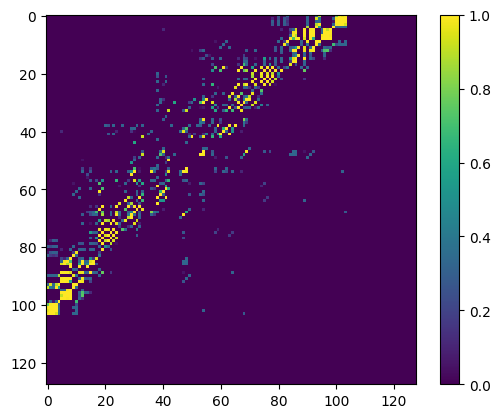

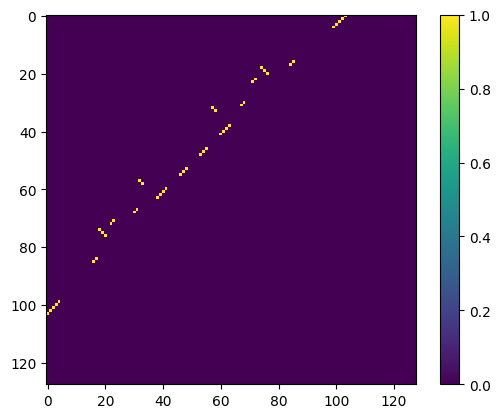

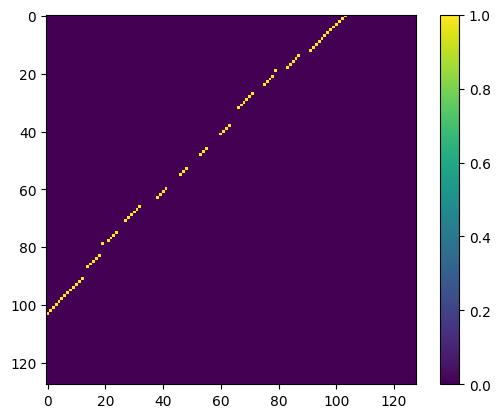

In [88]:
index = 0

pp = train_data["input"][0][index]
mask = train_data["mask"][index]
real = train_data["output"][index]
estimation = Estimator.predict([pp])

visualize.heatmap(estimation)
visualize.heatmap(model_2(pp, mask))
visualize.heatmap(real)

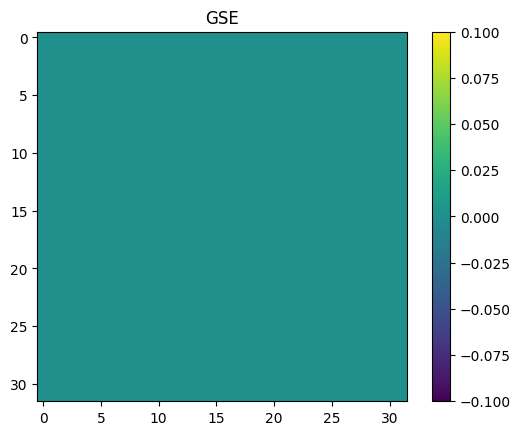

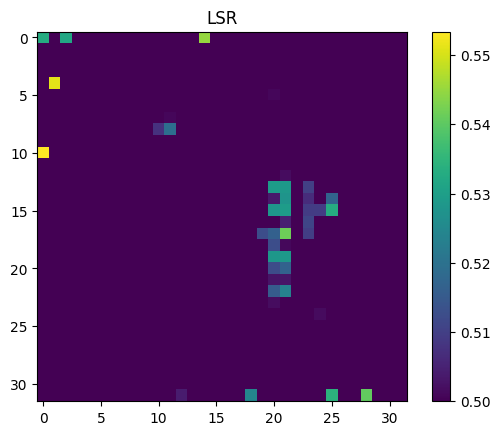

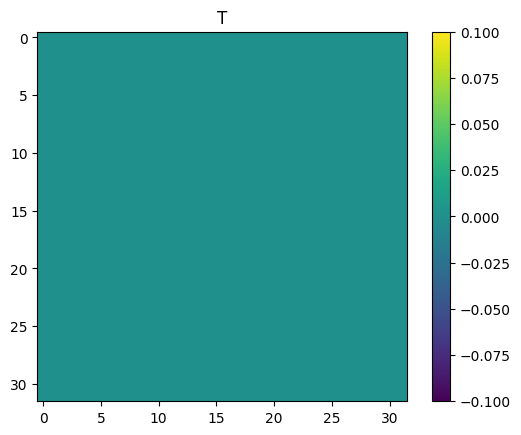

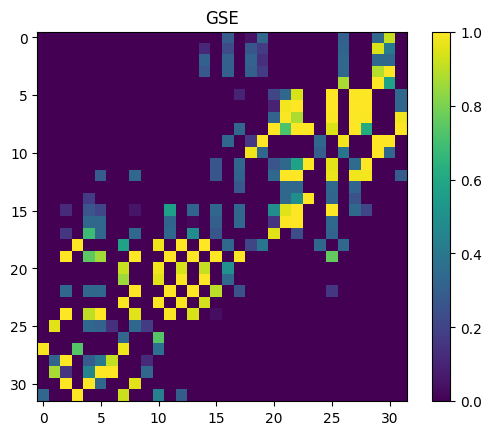

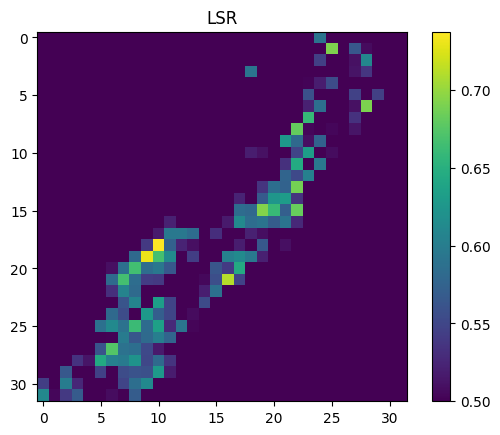

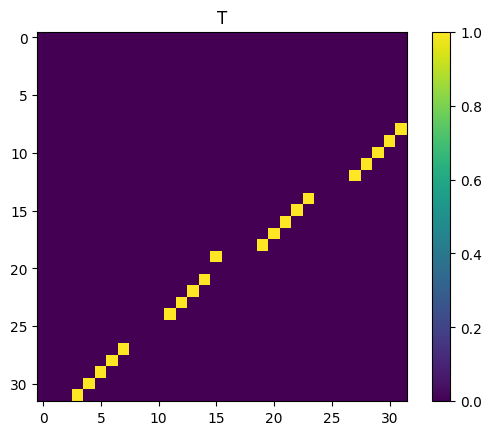

In [83]:
def refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE)):
        row = v_stride * SUBDIVISION_SIZE
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE)):
            column = h_stride * SUBDIVISION_SIZE
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] = prediction
    return result


refined_area = LSR.predict([estimation[:32, :32], pp[:32, :32]])
visualize.heatmap(estimation[:32, :32], "GSE")
visualize.heatmap(refined_area, "LSR")
visualize.heatmap(real[:32, :32], "T")


row, col = 0, 64
refined_area = LSR.predict([estimation[row:row+32, col:col+32], pp[row:row+32, col:col+32]])
visualize.heatmap(estimation[row:row+32, col:col+32], "GSE")
visualize.heatmap(refined_area, "LSR")
visualize.heatmap(real[row:row+32, col:col+32], "T")